# Understanding Hired Rides in NYC

## Project Setup

In [1]:
!pip install geopandas
!pip install fastparquet
!pip install keplergl
!jupyter nbextension install --py --sys-prefix keplergl
!jupyter nbextension enable --py --sys-prefix keplergl

Installing C:\Users\johnf\anaconda3\lib\site-packages\keplergl\static -> keplergl-jupyter
Up to date: C:\Users\johnf\anaconda3\share\jupyter\nbextensions\keplergl-jupyter\extension.js
Up to date: C:\Users\johnf\anaconda3\share\jupyter\nbextensions\keplergl-jupyter\extension.js.map
Up to date: C:\Users\johnf\anaconda3\share\jupyter\nbextensions\keplergl-jupyter\index.js
Up to date: C:\Users\johnf\anaconda3\share\jupyter\nbextensions\keplergl-jupyter\index.js.map
Up to date: C:\Users\johnf\anaconda3\share\jupyter\nbextensions\keplergl-jupyter\keplergl.html
Up to date: C:\Users\johnf\anaconda3\share\jupyter\nbextensions\keplergl-jupyter\main.js
- Validating: ok

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable keplergl --py --sys-prefix
    
Enabling notebook extension keplergl-jupyter/extension...
      - Validating: ok


In [2]:
import math
from math import sin, cos, sqrt, atan2, radians
import bs4
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import geopandas as gpd
import numpy as np
import re
import fastparquet
from keplergl import KeplerGl

In [51]:
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"
TAXI_SHPFILE = "taxi_zones.shp"
WEATHER_DATA_FILES = ["2009_weather.csv", "2010_weather.csv","2011_weather.csv",
                      "2012_weather.csv","2013_weather.csv","2014_weather.csv","2015_weather.csv" ]
NEWARK_BOX=[-74.205780,40.661560,-74.146042,40.711833]
LAGUARDIA_BOX=[-73.901854,40.754908,-73.847694,40.789443]
JFK_BOX=[-73.839455,40.618057,-73.736458,40.679565]

## Part 1: Data Preprocessing

### Calculating distance
The below function calculates the distance between two coordinates from degrees to kilometers that utilizes the math module. It converts pickup and dropoff latitude and longitude coordinates from degrees to radians because all trig functions in the math module use radianns, calculates distance between two coordinates and uses a formula to convert distance in radians to distance in kilometers

In [4]:
def calculate_distance(df):
    """Converts geographical coordinates from a dataframe into a list of distances in kilometers."""
    
    # Convert the coordinates into from degrees for use of trig functions.
    lat1 = []
    for coord in df["pickup_longitude"]: 
        lat1.append(radians(coord))
    
    lon1 = []
    for coord in df["pickup_latitude"]: 
        lon1.append(radians(coord))

    lat2 = []
    for coord in df["dropoff_longitude"]: 
        lat2.append(radians(coord))
    
    lon2 = []
    for coord in df["dropoff_latitude"]: 
        lon2.append(radians(coord))
        
    
    # Calculate difference in between coordinates. 
    diflon = list()
    for item1, item2 in zip(lon1, lon2): 
        diflon.append(item2 - item1)

    diflat = list()
    for item1, item2 in zip(lat1, lat2): 
        diflat.append(item2 - item1)  
        
        
    # Calculating distance using the quadratic formula.
    R = 6373.0
    dist = list()
    for rad1, rad2, item1, item2 in zip(diflon, diflat, lat1, lat2):
        a = sin(rad2 / 2)**2 + cos(item1) * cos(item2) * sin(rad1 / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c 
        dist.append(distance)
        
    return dist

In [5]:
def add_distance_column(df):
    """ Assigns distance values to its own column in a dataframe """
    df["distance"] = calculate_distance(df)
    return df 

### Processing Uber Data

Processing data before analyzing it is necessary to create a more efficient analysis. This function removes unnecessary columns, removes invalid data points, normalizes column names so that analyses later on can be generalized to a common name, and filters data to only show trips in a certain coordinate limit.

In [6]:
def load_and_clean_uber_data(csv_file):
    """Imports and reads the csv file of Uber data."""
    UBER_DATA = pd.read_csv(csv_file) 
    
    # Drop unnecessary columns from the dataset.
    UBER_DATA = UBER_DATA[["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]]
    
    # Drop rows from the dataset with invalid coordinate values.
    UBER_DATA = UBER_DATA[~(UBER_DATA[['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']] == 0).any(axis=1)] 
    
    # Define valid bounds for NYC coordinates.
    westlimit = -74.242330
    eastlimit = -73.717047

    southlimit = 40.560445
    northlimit = 40.908524
    
    # Fetch the coordinate values from the dataset.
    pickup_longitude = UBER_DATA['pickup_longitude'].values
    pickup_latitude = UBER_DATA['pickup_latitude'].values
    
    # Create filters for data within longitude limits.
    pickupwest = pickup_longitude >= westlimit
    pickupeast = pickup_longitude <= eastlimit 
    pickuplon = pickupwest * pickupeast 
    
    # Create filters for data within latitude limits.
    pickupnorth = pickup_latitude <= northlimit 
    pickupsouth = pickup_latitude >= southlimit
    pickuplat = pickupnorth * pickupsouth 
    
    # Create the final pickup filter.
    pickupfilter = pickuplon * pickuplat
        

    # Filter out dropoff data.
    dropoff_longitude = UBER_DATA['dropoff_longitude'].values
    dropoff_latitude = UBER_DATA['dropoff_latitude'].values
    
    # Create filters for data within longitude limits.
    dropoffwest = dropoff_longitude >= westlimit
    dropoffeast = dropoff_longitude <= eastlimit 
    dropofflon = dropoffwest * dropoffeast 
    
    # Create filters for data within latitude limits.
    dropoffnorth = dropoff_latitude <= northlimit 
    dropoffsouth = dropoff_latitude >= southlimit
    dropofflat = dropoffnorth * dropoffsouth 
    
    # Create final dropoff filter.
    dropofffilter = dropofflon * dropofflat
    
    # Create final boundary filter.
    finalfilter = pickupfilter * dropofffilter
    
    # Create the final filtered dataframe.
    UBER_DATA = UBER_DATA[finalfilter]
    
    # Normalize column datatypes.
    UBER_DATA["pickup_datetime"]=pd.to_datetime(UBER_DATA["pickup_datetime"])

    return UBER_DATA
    


In [7]:
def get_uber_data():
    """ Loads uber dataframe and uses add_distance function to calculate distance """
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe

### Processing Taxi Data

Processing data before analyzing it is necessary to create a more efficient analysis. The first function [find_taxi_csv_urls()] scrapes the provided taxi database url to collect the links for all other taxi data files. It uses regex to match a format of the desired files and append the links to a list. It then selects the link from the requested time period and puts the links in chronological order. The functions named get_and_clean_month_taxi_data() remove unnecessary columns, removes invalid data points, normalizes column names so that analyses later on can be generalized to a common name, filter data to only show trips in a certain coordinate limit, and randomly sample from the set so that the size of the final taxi dataset is comparable to that of the uber dataset. The format of the taxi dataframes were not normalized therefore, three different functions were created in order to accomodate the different formats. The last function [get_and_clean_taxi_data()] merges all of the dataframes into one

In [8]:
def find_taxi_csv_urls():
    """Fetches the download URLs from the NYC data source site."""
    response = requests.get(TAXI_URL)
    response_page = BeautifulSoup(response.content, "lxml")
    elements = response_page.find_all('a', href=True)

    list1 = []
    for ele in elements: 
        list1.append(ele['href'])
        
    # Use regex to math to desired format of the datafiles.
    links = []
    for i in range(455): 
        string = str(list1[i])
        pattern = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_20\d\d-\d\d.parquet"
        if re.search(pattern, string) is not None: 
            links.append(string)
            
    # Get only the links from the requested time period.
    links = links[80:]
    
    # Put links in chronological order.
    year15 = [] 
    months = ['-01','-02','-03','-04','-05','-06']# Fetch data only through June of 2015.
    year14 = []
    year13 = []
    year12 = []
    year11 = []
    year10 = []
    year09 = []
    
    for link in links:
        if '2009' in link:
            year09.append(link)
        elif '2010' in link:
            year10.append(link)
        elif '2011' in link:
            year11.append(link)
        elif '2012' in link:
            year12.append(link)
        elif '2012' in link:
            year12.append(link)
        elif '2013' in link:
            year13.append(link)
        elif '2014' in link:
            year14.append(link)
        elif '2015' in link:
            for month in months:
                if month in link:
                    year15.append(link)
    
    final_links = year09 + year10 + year11 + year12 + year13 + year14 + year15
   
    return final_links

In [9]:
def download_taxi_data(links):
    """Download the parquet data files using the links."""
    for link in links:
        filename = link[48:]
        response = requests.get(link)
        open(filename,'wb').write(response.content)

In [10]:
def get_and_clean_month_taxi_data1(url):
    """Filter and clean the taxi data for analysis purposes."""
    
    # Use regex to math to desired format of the datafiles.
    pattern1 = "yellow_tripdata_20\d\d-\d\d.parquet"
    if re.search(pattern1, url) is not None: 
        filename = re.search(pattern1, url).group()
    
    dataset = pd.read_parquet(filename, engine='fastparquet')
    
    dataset = dataset[["Trip_Pickup_DateTime", "Start_Lon", "Start_Lat", "End_Lon", "End_Lat","Tip_Amt"]]
    dataset = dataset.set_axis(["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude","tip_amount"], axis=1, inplace=False)
    df1 = dataset
    
    # Filter out rows with invalid coordinates.
    dataset = dataset[~(dataset[['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']] == 0).any(axis=1)] 
    
    # Define longitude and latitude bounds. 
    westlimit = -74.242330
    eastlimit = -73.717047
  
    southlimit = 40.560445
    northlimit = 40.908524
    
    # Filter out pickup data. 
    tpickup_longitude = dataset['pickup_longitude'].values
    tpickup_latitude = dataset['pickup_latitude'].values
    
    # Create filters for data within longitude limits.
    tpickupwest = tpickup_longitude >= westlimit
    tpickupeast = tpickup_longitude <= eastlimit 
    tpickuplon = tpickupwest * tpickupeast 
    
    # Create filters for data within latitude limits.
    tpickupnorth = tpickup_latitude <= northlimit 
    tpickupsouth = tpickup_latitude >= southlimit
    tpickuplat = tpickupnorth * tpickupsouth 
    
    # Create final pickup filter.
    tpickupfilter = tpickuplon * tpickuplat
        
    # Filter out dropoff data.
    tdropoff_longitude = dataset['dropoff_longitude'].values
    tdropoff_latitude = dataset['dropoff_latitude'].values
        
    # Create filters for data within longitude limits.
    tdropoffwest = tdropoff_longitude >= westlimit
    tdropoffeast = tdropoff_longitude <= eastlimit 
    tdropofflon = tdropoffwest * tdropoffeast 
    
    # Create filters for data within latitude limits.
    tdropoffnorth = tdropoff_latitude <= northlimit 
    tdropoffsouth = tdropoff_latitude >= southlimit
    tdropofflat = tdropoffnorth * tdropoffsouth 
    
    # Create final dropoff filter.
    tdropofffilter = tdropofflon * tdropofflat
    
    # Define final boundary filter.
    tfinalfilter = tpickupfilter * tdropofffilter
    
    # Apply the final filter to the dataframe.
    dataset = dataset[tfinalfilter]
    
    # Create a random sample of data to match the size of the Uber dataset (2380 rows from each taxi dataset).
    dataset = dataset.sample(2380)
    
    # Normalize column datatypes.
    dataset["pickup_datetime"]=pd.to_datetime(dataset["pickup_datetime"])

    
    return dataset

In [11]:
def get_and_clean_month_taxi_data2(url):
    """Filter and clean the taxi data for analysis purposes."""

    # Use regex to math to desired format of the datafiles.
    pattern1 = "yellow_tripdata_20\d\d-\d\d.parquet"
    if re.search(pattern1, url) is not None: 
        filename = re.search(pattern1, url).group()
    
    dataset = pd.read_parquet(filename, engine='fastparquet')
    
    dataset = dataset[["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude","tip_amount"]]
    
    # Filter and remove rows with invalid coordinates.
    dataset = dataset[~(dataset[['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']] == 0).any(axis=1)] 
    
    # Define longitude and latitude bounds.
    westlimit = -74.242330
    eastlimit = -73.717047

    southlimit = 40.560445
    northlimit = 40.908524
    
    # Filter out pickup data.
    tpickup_longitude = dataset['pickup_longitude'].values
    tpickup_latitude = dataset['pickup_latitude'].values
    
    # Create filters for data within longitude limits.
    tpickupwest = tpickup_longitude >= westlimit
    tpickupeast = tpickup_longitude <= eastlimit 
    tpickuplon = tpickupwest * tpickupeast 
    
    # Create filters for data within latitude limits. 
    tpickupnorth = tpickup_latitude <= northlimit 
    tpickupsouth = tpickup_latitude >= southlimit
    tpickuplat = tpickupnorth * tpickupsouth 
    
    # Create final pickup filter.
    tpickupfilter = tpickuplon * tpickuplat
    
    # filtering out dropoff data
    tdropoff_longitude = dataset['dropoff_longitude'].values
    tdropoff_latitude = dataset['dropoff_latitude'].values
        
    # Create filters for data within longitude limits.
    tdropoffwest = tdropoff_longitude >= westlimit
    tdropoffeast = tdropoff_longitude <= eastlimit 
    tdropofflon = tdropoffwest * tdropoffeast 
    
    # Create filters for data within latitude limits. 
    tdropoffnorth = tdropoff_latitude <= northlimit 
    tdropoffsouth = tdropoff_latitude >= southlimit
    tdropofflat = tdropoffnorth * tdropoffsouth 
    
    # Create final dropoff filter.
    tdropofffilter = tdropofflon * tdropofflat
    
    # Create final boundary filter.
    tfinalfilter = tpickupfilter * tdropofffilter
    
    # Apply final filter to dataframe.
    dataset = dataset[tfinalfilter]
    
    # Create a random sample of data to match the size of the Uber dataset (2380 rows from each taxi dataset).
    dataset = dataset.sample(2380)
    
    # Normalize column datatypes.
    dataset["pickup_datetime"]=pd.to_datetime(dataset["pickup_datetime"])
    
    return dataset

In [12]:
def get_and_clean_month_taxi_data3(url):
    """Filter and clean the taxi data for analysis purposes."""

    # Import shapefile.
    shapefile = gpd.read_file(TAXI_SHPFILE)
    
    # Use imported shapefile to convert location IDs to coordinate values.
    shapefile = shapefile[["LocationID","geometry"]]
    shapefile = shapefile.to_crs(epsg = 4326)
    
    # Create new longitude and latitude columns.
    shapefile["lon"] = shapefile.geometry.centroid.x
    shapefile["lat"] = shapefile.geometry.centroid.y
    shapefile.index = np.arange(1,264)
    shapefile = shapefile[['lon','lat']]
    longitude = shapefile['lon']
    latitude = shapefile['lat']
    
    # Use regex to math to desired format of the datafiles.
    pattern = "yellow_tripdata_20\d\d-\d\d.parquet"
    if re.search(pattern, url) is not None: 
        filename = re.search(pattern, url).group()
    
    dataset = pd.read_parquet(filename, engine='fastparquet')
    dataset = dataset[["tpep_pickup_datetime", "PULocationID", "DOLocationID", "trip_distance"]]
    dataset = dataset.set_axis(["pickup_datetime", "PULocationID", "DOLocationID", "distance"], axis=1, inplace=False)
    
    # Create boolean masks for valid Location IDs.
    pulocationidfilter = dataset['PULocationID'] <= 263
    dolocationidfilter = dataset['DOLocationID'] <= 263
    validityfilter = pulocationidfilter & dolocationidfilter
    
    dataset = dataset[validityfilter] # Get rid  of nonvalid IDs. 

    pulon = []
    pulat = []
    for idpu in dataset['PULocationID']: 
        pulon.append(longitude[idpu])
        pulat.append(latitude[idpu])
        
    dataset['pickup_longitude'] = pulon
    dataset['pickup_latitude'] = pulat
        
    dolon = []
    dolat = []
    for iddo in dataset['DOLocationID']: 
        dolon.append(longitude[iddo])
        dolat.append(latitude[iddo])
        
    dataset['dropoff_longitude'] = dolon
    dataset['dropoff_latitude'] = dolat
    
    dataset = dataset[["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]]
    
    # Filter rows with invalid coordinates.
    dataset = dataset[~(dataset[['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']] == 0).any(axis=1)] 
    
    # Define longitude and latitude bounds.
    westlimit = -74.242330
    eastlimit = -73.717047
     
    southlimit = 40.560445
    northlimit = 40.908524
    
    # Filter out pickup data. 
    tpickup_longitude = dataset['pickup_longitude'].values
    tpickup_latitude = dataset['pickup_latitude'].values
    
    # Create filters for data within longitude limits.
    tpickupwest = tpickup_longitude >= westlimit
    tpickupeast = tpickup_longitude <= eastlimit 
    tpickuplon = tpickupwest * tpickupeast 
    
    # Create filters for data within latitude limits.
    tpickupnorth = tpickup_latitude <= northlimit 
    tpickupsouth = tpickup_latitude >= southlimit
    tpickuplat = tpickupnorth * tpickupsouth 
    
    # Create final pickup filter.
    tpickupfilter = tpickuplon * tpickuplat 

    # Filter out dropoff data.
    tdropoff_longitude = dataset['dropoff_longitude'].values
    tdropoff_latitude = dataset['dropoff_latitude'].values
        
    # Create filters for data within longitude limits. 
    tdropoffwest = tdropoff_longitude >= westlimit
    tdropoffeast = tdropoff_longitude <= eastlimit 
    tdropofflon = tdropoffwest * tdropoffeast 
    
    # Create filters for data within latitude limits. 
    tdropoffnorth = tdropoff_latitude <= northlimit 
    tdropoffsouth = tdropoff_latitude >= southlimit
    tdropofflat = tdropoffnorth * tdropoffsouth 
    
    # Create final dropoff filter. 
    tdropofffilter = tdropofflon * tdropofflat
    
    # Create final boundary filter.
    tfinalfilter = tpickupfilter * tdropofffilter
    
    # Apply final filter to dataframe.
    dataset = dataset[tfinalfilter]
    
    # Create a random sample of data to match the size of the Uber dataset (2380 rows from each taxi dataset).
    dataset = dataset.sample(2380)
    
    # Normalize column datatypes.
    dataset["pickup_datetime"]=pd.to_datetime(dataset["pickup_datetime"])
              
    return dataset
  

In [13]:
def get_and_clean_taxi_data():
    """Apply all created filters and concatinate into one dataframe."""
    all_taxi_dataframes = []
    taxi_urls = find_taxi_csv_urls()
    
    # Split urls. 
    csv_urls1 = taxi_urls[:12]
    csv_urls2 = taxi_urls[12:24]
    csv_urls3 = taxi_urls[24:]

    # Apply preprocessing functions to applicable dataframes.
    for csv_url in csv_urls1:
        dataframe1 = get_and_clean_month_taxi_data1(csv_url)
        add_distance_column(dataframe1)
        all_taxi_dataframes.append(dataframe1)
    for csv_url in csv_urls2:
        dataframe2 = get_and_clean_month_taxi_data2(csv_url)
        add_distance_column(dataframe2)
        all_taxi_dataframes.append(dataframe2)
    for csv_url in csv_urls3:
        dataframe3 = get_and_clean_month_taxi_data3(csv_url)
        add_distance_column(dataframe3)
        all_taxi_dataframes.append(dataframe3)
        
    # Create one dataframe with data from every month needed.
    taxi_data = []
    for dataframe in all_taxi_dataframes: 
        taxi_data.append(dataframe)
        
                            
    return taxi_data

### Processing Weather Data

In this section, the processesing of data before performing analyses continues. The data is split into two different dataframes so that alayses can be run at different frequencies. NaN and invalid data points are dropped as part of cleaning the data. Regex is also used to extract just didgits from the dataframe.

In [14]:
def clean_month_weather_data_hourly(csv_file):
    """Filter and clean the weather data for analysis."""
    
    # Import/read csv file.
    data = pd.read_csv(csv_file, low_memory = False) 
    
    # Clean dataframe by dropping NAN values.
    cleaned_data = data.dropna(axis=0, subset = "HourlyPrecipitation") 
    
    # Remove rows with trace ('T') values.
    cleaned_data = cleaned_data[~(cleaned_data["HourlyPrecipitation"] == 'T')]
    
    # Only extract digits from Hourly Precipitation column. 
    cleaned_data["HourlyPrecipitation"] = cleaned_data["HourlyPrecipitation"].replace('\(|[a-zA-Z]+', '', regex=True)
    
    # Drop NAN values for wind speed.
    cleaned_data = cleaned_data.dropna(axis=0, subset = "HourlyWindSpeed") 
    
    # Create a dataframe with only the necessary columns. 
    cleaned_data = cleaned_data[["DATE","HourlyPrecipitation","HourlyWindSpeed"]]
    
    # Standardize datatypes.
    cleaned_data["DATE"] = pd.to_datetime(cleaned_data["DATE"])
    cleaned_data["HourlyPrecipitation"] = pd.to_numeric(cleaned_data["HourlyPrecipitation"])
    
    return cleaned_data

In [15]:
def clean_month_weather_data_daily(csv_file):
    """Create Daily Weather dataframe"""
    
    # Load cleaned hourly data.
    cleaned_hourly = clean_month_weather_data_hourly(csv_file)
    
    # Group by each date and assign the average of the hourly values to a daily value.
    daily = cleaned_hourly.groupby([cleaned_hourly['DATE'].dt.date]).mean()
    
    return daily

In [16]:
def load_and_clean_weather_data():
    """Generate the final weather dataframes."""
    hourly_dataframes = []
    daily_dataframes = []
    
    # Add the name/paths.
    weather_csv_files = WEATHER_DATA_FILES
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # Create two dataframes with hourly & daily data from every source.
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

### Process All Data

After writing the code for cleaning and preprocessing all of the data, the below cells are meant to execute all of the required functions and by default make sure they all run properly. 

In [17]:
download_taxi_data(find_taxi_csv_urls())
taxi_data = get_and_clean_taxi_data()

C:\Users\johnf\AppData\Local\Temp\ipykernel_11084\2362986740.py:12: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dataset = dataset.set_axis(["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude","tip_amount"], axis=1, inplace=False)
C:\Users\johnf\AppData\Local\Temp\ipykernel_11084\2362986740.py:12: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dataset = dataset.set_axis(["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude","tip_amount"], axis=1, inplace=False)
C:\Users\johnf\AppData\Local\Temp\ipykernel_11084\2362986740.py:12: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` i

In [18]:
taxi_data = pd.concat(taxi_data)
taxi_data

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,distance
12836762,2009-01-10 16:18:14,-73.987229,40.741732,-73.979727,40.752360,0.00,0.895929
10774258,2009-01-10 14:02:44,-73.991523,40.751214,-73.998404,40.740433,0.00,0.833736
7859722,2009-01-16 22:43:07,-73.789258,40.645961,-73.966118,40.684546,0.00,19.708175
12198284,2009-01-09 00:00:29,-74.005523,40.740594,-73.956958,40.769753,1.95,5.475519
1213537,2009-01-21 20:36:00,-73.981728,40.759697,-73.975507,40.790417,0.00,1.169699
...,...,...,...,...,...,...,...
5281559,2015-06-13 12:36:09,-73.994305,40.732579,-73.965635,40.768615,NaN,3.375391
5908990,2015-06-14 23:21:04,-73.981532,40.773633,-73.989845,40.762253,NaN,0.988344
5933239,2015-06-15 04:21:33,-73.922240,40.694994,-73.922251,40.652365,NaN,1.313167
10629272,2015-06-26 17:19:59,-73.957012,40.780436,-73.981532,40.773633,NaN,2.735406


In [19]:
uber_data = get_uber_data()
uber_data

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,0.465327
1,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,0.678941
2,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,4.825036
3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,1.262035
4,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5.371588
...,...,...,...,...,...,...
199995,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,0.064197
199996,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,2.442986
199997,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,14.269270
199998,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1.800660


In [20]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()
daily_weather_data = daily_weather_data.rename(columns={'HourlyPrecipitation':'DailyPrecipitation',
                                  'HourlyWindSpeed':'DailyWindSpeed'})
daily_weather_data

C:\Users\johnf\AppData\Local\Temp\ipykernel_11084\183201642.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily = cleaned_hourly.groupby([cleaned_hourly['DATE'].dt.date]).mean()
C:\Users\johnf\AppData\Local\Temp\ipykernel_11084\183201642.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily = cleaned_hourly.groupby([cleaned_hourly['DATE'].dt.date]).mean()
C:\Users\johnf\AppData\Local\Temp\ipykernel_11084\183201642.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or sel

,DailyPrecipitation,DailyWindSpeed
DATE,,
2009-01-06,0.017143,8.857143
2009-01-07,0.058710,10.387097
2009-01-10,0.020500,9.250000
2009-01-11,0.039231,8.769231
2009-01-15,0.010000,7.000000
...,...,...
2015-12-27,0.007391,5.521739
2015-12-28,0.001500,8.150000
2015-12-29,0.028182,7.303030


## Part 2: Storing Cleaned Data

While the dataframes we have stored our data in are convenient for coding purposes, they are impermanent and take a long time to process, so we would like to store them so that we do not have to generate them every time. We do this by writing them into SQL tables in a database we define. We will name our database "project.db" and write our dataframes into it by using Pandas' .to_sql functionality.

In [21]:
engine = db.create_engine('sqlite:///project.db')

In [22]:
hourly_weather_data.to_sql('hourlyWeather',con=engine, if_exists='replace',index_label='id')
daily_weather_data.to_sql('dailyWeather',con=engine, if_exists='replace',index_label='id')
uber_data.to_sql('uber',con=engine, if_exists='replace',index_label='id')
taxi_data.to_sql('taxi',con=engine, if_exists='replace',index_label='id')

185640

## Part 3: Understanding the Data

In this section, we will run several queries on the data we have stored in SQL tables. We do this to get a better understanding of the shape and scope of our data. For each query, we have a particular question in mind that we will answer by calling relevant data. At times, we may summarize the data by counting rows or taking averages. In the next cell, we define a function that will write the prose of our queries into .sql files so that we can call them later without having to write them again.

In [23]:
def write_query_to_file(query, outfile):
    """Write a given SQL query string to a file called outfile."""
    f = open(outfile,'w')
    f.write(query)
    f.close()

### Query 1

Here we will find what hour of the day was the most popular to take a Yellow Taxi by counting the number of rows in our table corresponding to each hour of the day.

In [24]:
QUERY_1 = """
SELECT 
COUNT(CASE WHEN pickup_datetime LIKE '%00:%' THEN 1 END) AS '00',
COUNT(CASE WHEN pickup_datetime LIKE '%01:%' THEN 1 END) AS '01',
COUNT(CASE WHEN pickup_datetime LIKE '%02:%' THEN 1 END) AS '02',
COUNT(CASE WHEN pickup_datetime LIKE '%03:%' THEN 1 END) AS '03',
COUNT(CASE WHEN pickup_datetime LIKE '%04:%' THEN 1 END) AS '04',
COUNT(CASE WHEN pickup_datetime LIKE '%05:%' THEN 1 END) AS '05',
COUNT(CASE WHEN pickup_datetime LIKE '%06:%' THEN 1 END) AS '06',
COUNT(CASE WHEN pickup_datetime LIKE '%07:%' THEN 1 END) AS '07',
COUNT(CASE WHEN pickup_datetime LIKE '%08:%' THEN 1 END) AS '08',
COUNT(CASE WHEN pickup_datetime LIKE '%09:%' THEN 1 END) AS '09',
COUNT(CASE WHEN pickup_datetime LIKE '%10:%' THEN 1 END) AS '10',
COUNT(CASE WHEN pickup_datetime LIKE '%11:%' THEN 1 END) AS '11',
COUNT(CASE WHEN pickup_datetime LIKE '%12:%' THEN 1 END) AS '12',
COUNT(CASE WHEN pickup_datetime LIKE '%13:%' THEN 1 END) AS '13',
COUNT(CASE WHEN pickup_datetime LIKE '%14:%' THEN 1 END) AS '14',
COUNT(CASE WHEN pickup_datetime LIKE '%15:%' THEN 1 END) AS '15',
COUNT(CASE WHEN pickup_datetime LIKE '%16:%' THEN 1 END) AS '16',
COUNT(CASE WHEN pickup_datetime LIKE '%17:%' THEN 1 END) AS '17',
COUNT(CASE WHEN pickup_datetime LIKE '%18:%' THEN 1 END) AS '18',
COUNT(CASE WHEN pickup_datetime LIKE '%19:%' THEN 1 END) AS '19',
COUNT(CASE WHEN pickup_datetime LIKE '%20:%' THEN 1 END) AS '20',
COUNT(CASE WHEN pickup_datetime LIKE '%21:%' THEN 1 END) AS '21',
COUNT(CASE WHEN pickup_datetime LIKE '%22:%' THEN 1 END) AS '22',
COUNT(CASE WHEN pickup_datetime LIKE '%23:%' THEN 1 END) AS '23'
FROM taxi
"""

In [25]:
engine.execute(QUERY_1).fetchall()

[(10407, 8228, 7092, 6050, 5244, 4767, 6815, 9710, 11410, 11590, 11259, 11518, 12140, 12067, 12504, 11699, 10712, 12270, 13929, 14518, 13877, 13491, 13079, 12279)]

In [26]:
write_query_to_file(QUERY_1, "popular_taxi_hours.sql")

### Query 2

Here we will find what day was the most popular to take an Uber by counting the number of rows in our table corresponding to each day of the week.


In [27]:
QUERY_2 = """
SELECT
COUNT(CASE WHEN strftime('%w',pickup_datetime) IS '0' THEN 1 END) AS 'Sunday',
COUNT(CASE WHEN strftime('%w',pickup_datetime) IS '1' THEN 1 END) AS 'Monday',
COUNT(CASE WHEN strftime('%w',pickup_datetime) IS '2' THEN 1 END) AS 'Tuesday',
COUNT(CASE WHEN strftime('%w',pickup_datetime) IS '3' THEN 1 END) AS 'Wednesday',
COUNT(CASE WHEN strftime('%w',pickup_datetime) IS '4' THEN 1 END) AS 'Thursday',
COUNT(CASE WHEN strftime('%w',pickup_datetime) IS '5' THEN 1 END) AS 'Friday',
COUNT(CASE WHEN strftime('%w',pickup_datetime) IS '6' THEN 1 END) AS 'Saturday'
FROM uber
"""

In [28]:
engine.execute(QUERY_2).fetchall()

[(25834, 24681, 27526, 28328, 29338, 30166, 29599)]

In [29]:
write_query_to_file(QUERY_2, "popular_uber_days.sql")

### Query 3

Here we will find the 95% percentile of distance traveled for all hired trips during July 2013 by forming a union between our Yellow Taxi data and Uber data and finding what distance encompasses 95% of all rides.


In [30]:
QUERY_3 = """
SELECT distance
FROM taxi

UNION ALL

SELECT distance
FROM uber
ORDER BY distance DESC
LIMIT 1 OFFSET 19055
"""

In [31]:
engine.execute(QUERY_3).fetchall()

[(10.460477712943486,)]

In [32]:
write_query_to_file(QUERY_3, "rides_95th_percentile.sql")

### Query 4

Here we find the 10 days with the most hired rides and their average distance by filtering our union and grouping by day. We then order by number of rides per day and select the top 10 days.

In [35]:
QUERY_4 = """
SELECT pickup_datetime, AVG(distance)
FROM (
SELECT pickup_datetime, distance
FROM taxi
WHERE pickup_datetime LIKE '2009%'

UNION ALL

SELECT pickup_datetime, distance
FROM uber
WHERE pickup_datetime LIKE '2009%'
)
GROUP BY pickup_datetime
ORDER BY COUNT(pickup_datetime) DESC
LIMIT 10
"""

In [36]:
engine.execute(QUERY_4).fetchall()

[('2009-06-22 21:32:00.000000', 4.536256645971338),
 ('2009-02-12 12:46:00.000000', 2.06106123864422),
 ('2009-12-22 20:38:00.000000', 0.4025848635120985),
 ('2009-11-30 11:12:00.000000', 0.9908201467668709),
 ('2009-11-10 13:49:00.000000', 1.2758689786703445),
 ('2009-11-05 23:39:00.000000', 3.015314787749366),
 ('2009-11-02 15:05:00.000000', 1.3182401636844032),
 ('2009-10-22 23:49:00.000000', 5.255898472608101),
 ('2009-10-20 22:00:00.000000', 0.9420834888315079),
 ('2009-10-20 20:23:00.000000', 1.099002017983353)]

In [37]:
write_query_to_file(QUERY_4, "avg_dist_of_busiest_days_2009.sql")

### Query 5

Here we will find what days in 2014 were the windiest and how many rides were taken on those days by grouping our rides by the day, joining with our daily weather reports, and ordering by windiest days.


In [38]:
QUERY_5 = """
SELECT strftime('%Y-%m-%d',pickup_datetime) AS date, COUNT(
    (SELECT distance FROM taxi WHERE pickup_datetime LIKE '2014%'
    UNION ALL
    SELECT distance FROM uber WHERE pickup_datetime LIKE '2014%'
    ) 
    )
FROM (
SELECT pickup_datetime
FROM taxi
WHERE pickup_datetime LIKE '2014%'

UNION ALL

SELECT pickup_datetime
FROM uber
WHERE pickup_datetime LIKE '2014%'
) AS a

JOIN dailyWeather ON strftime('%Y-%m-%d',a.pickup_datetime)=dailyWeather.id
GROUP BY strftime('%Y-%m-%d',pickup_datetime)
ORDER BY dailyWeather.DailyWindSpeed DESC
LIMIT 10
"""

In [39]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 203),
 ('2014-01-07', 170),
 ('2014-01-02', 120),
 ('2014-02-13', 114),
 ('2014-03-26', 173),
 ('2014-03-29', 189),
 ('2014-12-07', 159),
 ('2014-12-09', 151),
 ('2014-12-08', 137),
 ('2014-11-02', 164)]

In [40]:
write_query_to_file(QUERY_5, "windy_days_with_trips.sql")

### Query 6

Here we will find the number of rides taken, precipitation and wind speed for every hour in the two week period surrounding Hurricane Sandy's presence in NYC. We group our rides by hour and limit our search to the desired time period.


In [41]:
QUERY_6 = """
SELECT COUNT(
    (SELECT distance FROM taxi WHERE (
       pickup_datetime LIKE '2012-10-22%'
    OR pickup_datetime LIKE '2012-10-23%'
    OR pickup_datetime LIKE '2012-10-24%'
    OR pickup_datetime LIKE '2012-10-25%'
    OR pickup_datetime LIKE '2012-10-26%'
    OR pickup_datetime LIKE '2012-10-27%'
    OR pickup_datetime LIKE '2012-10-28%'
    OR pickup_datetime LIKE '2012-10-29%'
    OR pickup_datetime LIKE '2012-10-30%'
    OR pickup_datetime LIKE '2012-10-31%'
    OR pickup_datetime LIKE '2012-11-01%'
    OR pickup_datetime LIKE '2012-11-02%'
    OR pickup_datetime LIKE '2012-11-03%'
    OR pickup_datetime LIKE '2012-11-04%'
    OR pickup_datetime LIKE '2012-11-05%'
    OR pickup_datetime LIKE '2012-11-06%'
    )
    
    UNION ALL
    
    SELECT distance FROM uber WHERE (
       pickup_datetime LIKE '2012-10-22%'
    OR pickup_datetime LIKE '2012-10-23%'
    OR pickup_datetime LIKE '2012-10-24%'
    OR pickup_datetime LIKE '2012-10-25%'
    OR pickup_datetime LIKE '2012-10-26%'
    OR pickup_datetime LIKE '2012-10-27%'
    OR pickup_datetime LIKE '2012-10-28%'
    OR pickup_datetime LIKE '2012-10-29%'
    OR pickup_datetime LIKE '2012-10-30%'
    OR pickup_datetime LIKE '2012-10-31%'
    OR pickup_datetime LIKE '2012-11-01%'
    OR pickup_datetime LIKE '2012-11-02%'
    OR pickup_datetime LIKE '2012-11-03%'
    OR pickup_datetime LIKE '2012-11-04%'
    OR pickup_datetime LIKE '2012-11-05%'
    OR pickup_datetime LIKE '2012-11-06%'
    ) 
    )), hourlyWeather.HourlyPrecipitation, hourlyWeather.HourlyWindSpeed
FROM (
    SELECT distance, pickup_datetime FROM taxi WHERE (
       pickup_datetime LIKE '2012-10-22%'
    OR pickup_datetime LIKE '2012-10-23%'
    OR pickup_datetime LIKE '2012-10-24%'
    OR pickup_datetime LIKE '2012-10-25%'
    OR pickup_datetime LIKE '2012-10-26%'
    OR pickup_datetime LIKE '2012-10-27%'
    OR pickup_datetime LIKE '2012-10-28%'
    OR pickup_datetime LIKE '2012-10-29%'
    OR pickup_datetime LIKE '2012-10-30%'
    OR pickup_datetime LIKE '2012-10-31%'
    OR pickup_datetime LIKE '2012-11-01%'
    OR pickup_datetime LIKE '2012-11-02%'
    OR pickup_datetime LIKE '2012-11-03%'
    OR pickup_datetime LIKE '2012-11-04%'
    OR pickup_datetime LIKE '2012-11-05%'
    OR pickup_datetime LIKE '2012-11-06%'
    )
    
    UNION ALL
    
    SELECT distance, pickup_datetime FROM uber WHERE (
       pickup_datetime LIKE '2012-10-22%'
    OR pickup_datetime LIKE '2012-10-23%'
    OR pickup_datetime LIKE '2012-10-24%'
    OR pickup_datetime LIKE '2012-10-25%'
    OR pickup_datetime LIKE '2012-10-26%'
    OR pickup_datetime LIKE '2012-10-27%'
    OR pickup_datetime LIKE '2012-10-28%'
    OR pickup_datetime LIKE '2012-10-29%'
    OR pickup_datetime LIKE '2012-10-30%'
    OR pickup_datetime LIKE '2012-10-31%'
    OR pickup_datetime LIKE '2012-11-01%'
    OR pickup_datetime LIKE '2012-11-02%'
    OR pickup_datetime LIKE '2012-11-03%'
    OR pickup_datetime LIKE '2012-11-04%'
    OR pickup_datetime LIKE '2012-11-05%'
    OR pickup_datetime LIKE '2012-11-06%'
    )
) AS a
JOIN hourlyWeather ON strftime('%Y-%m-%d %H',a.pickup_datetime)=strftime('%Y-%m-%d %H',hourlyWeather.date)
GROUP BY strftime('%Y-%m-%d %H',a.pickup_datetime)
"""

In [42]:
engine.execute(QUERY_6).fetchall()

[(2, 0.0, 7.0),
 (1, 0.0, 7.0),
 (2, 0.0, 0.0),
 (1, 0.0, 0.0),
 (1, 0.0, 0.0),
 (9, 0.0, 5.0),
 (9, 0.0, 3.0),
 (6, 0.0, 3.0),
 (6, 0.0, 5.0),
 (9, 0.0, 11.0),
 (3, 0.0, 7.0),
 (8, 0.0, 6.0),
 (12, 0.0, 3.0),
 (7, 0.0, 7.0),
 (13, 0.0, 5.0),
 (7, 0.0, 5.0),
 (13, 0.0, 3.0),
 (6, 0.0, 0.0),
 (10, 0.0, 3.0),
 (4, 0.0, 3.0),
 (10, 0.02, 0.0),
 (13, 0.01, 0.0),
 (7, 0.0, 5.0),
 (1, 0.0, 7.0),
 (1, 0.0, 7.0),
 (2, 0.0, 6.0),
 (2, 0.0, 3.0),
 (9, 0.0, 7.0),
 (9, 0.0, 7.0),
 (5, 0.0, 8.0),
 (5, 0.0, 7.0),
 (7, 0.0, 7.0),
 (7, 0.0, 8.0),
 (10, 0.0, 5.0),
 (6, 0.0, 7.0),
 (8, 0.0, 8.0),
 (11, 0.0, 3.0),
 (17, 0.0, 5.0),
 (12, 0.0, 6.0),
 (8, 0.0, 0.0),
 (6, 0.0, 3.0),
 (1, 0.0, 3.0),
 (3, 0.0, 3.0),
 (1, 0.0, 7.0),
 (1, 0.0, 6.0),
 (4, 0.0, 0.0),
 (5, 0.0, 5.0),
 (3, 0.0, 6.0),
 (13, 0.0, 5.0),
 (8, 0.0, 3.0),
 (9, 0.0, 6.0),
 (10, 0.0, 0.0),
 (13, 0.0, 6.0),
 (8, 0.0, 0.0),
 (7, 0.0, 5.0),
 (11, 0.0, 5.0),
 (5, 0.0, 0.0),
 (8, 0.0, 3.0),
 (13, 0.0, 0.0),
 (6, 0.0, 0.0),
 (18, 0.0, 3.0),
 (17,

In [43]:
write_query_to_file(QUERY_6, "hurricane_rides_and_weather_by_hour.sql")

### Visualization N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

# Part 4: Visualizing the Data

### Visualization 1

In [44]:
ride = engine.execute(QUERY_1).fetchall()
ride = [10411, 8381, 7193, 5995, 5141, 4772, 6886, 9811, 11447, 11493, 11395, 11657, 11777, 11994,
        12458, 11738, 10628, 12089, 14223, 14606, 13841, 13609, 13187, 12311]
rides = sorted(ride,reverse = True)
hour = [19, 18, 20, 21, 22, 14, 23, 17, 13, 12, 15, 11, 9, 8, 10, 16, 0, 7, 1, 2, 6, 3, 4, 5] 
hour = [str(h) for h in hour]

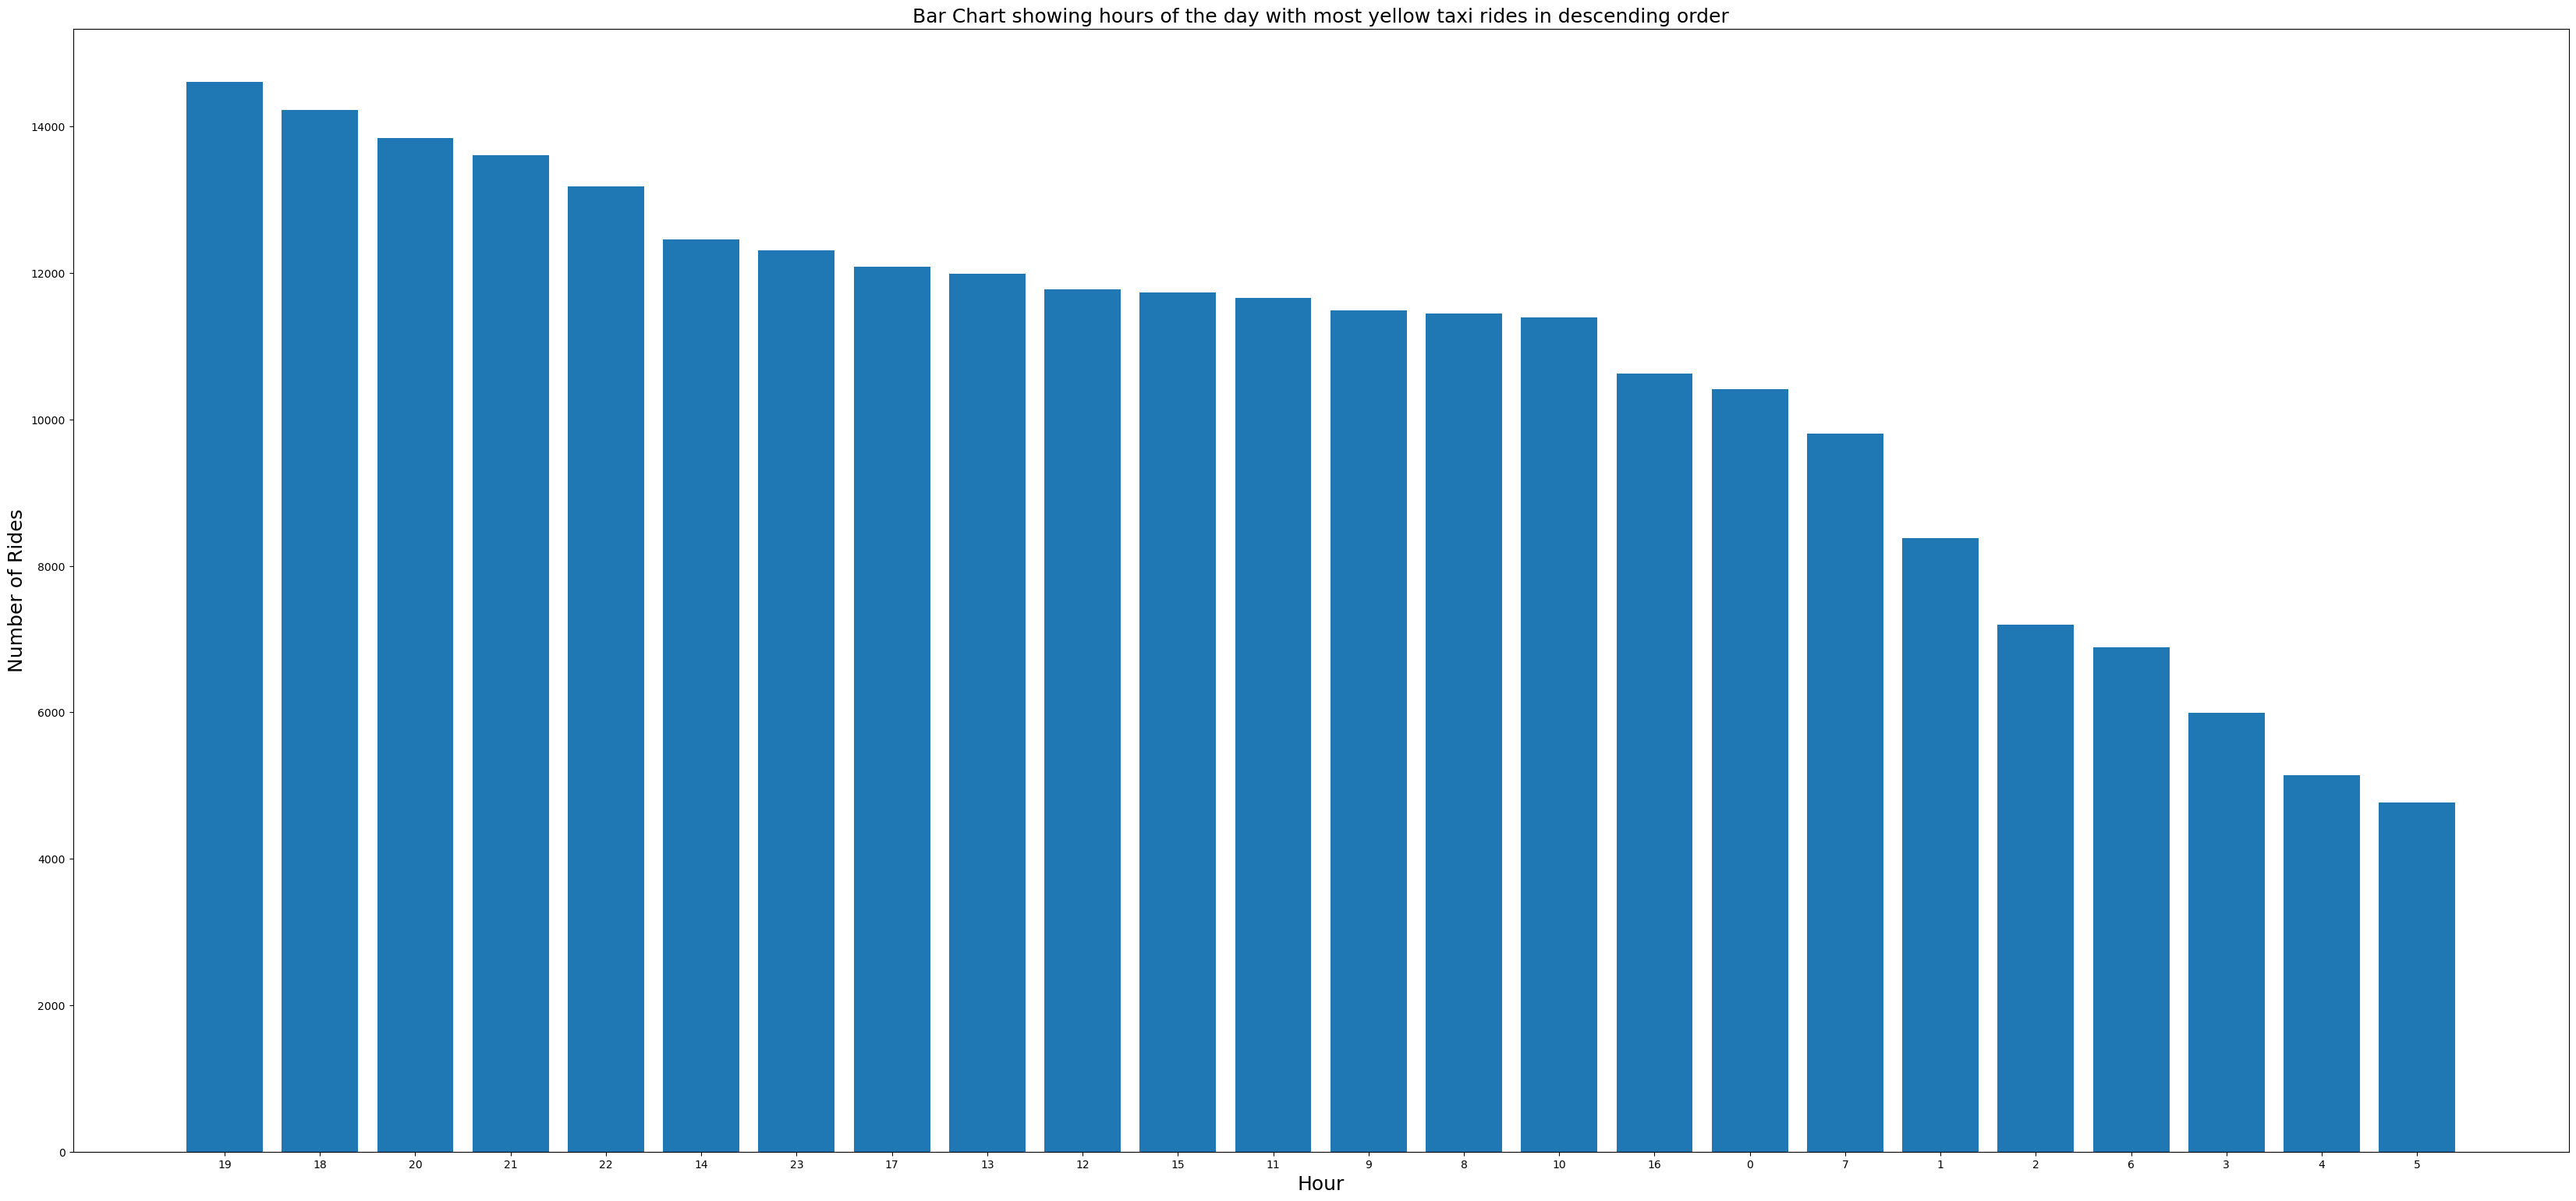

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,5,3])
ax.set_xlabel('Hour',fontsize=18)
ax.set_ylabel('Number of Rides',fontsize=18)
ax.set_title("Bar Chart showing hours of the day with most yellow taxi rides in descending order",fontsize=18)
ax.bar(hour,rides)
plt.show()

### Visualization 2

Here we create a line chart that shows the average distance traveled per month (regardless of year) for both taxis and Ubers combined. The red band represents the 90% confidence interval around the mean for each month.

In [46]:
df_uber=pd.read_sql("Select distance,pickup_datetime from uber",con=engine)
df_yellow=pd.read_sql("Select distance,pickup_datetime from taxi",con=engine)
df_combined=df_uber.append(df_yellow)

C:\Users\johnf\AppData\Local\Temp\ipykernel_11084\4126225506.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined=df_uber.append(df_yellow)


In [47]:
def plot_visual_2(df_combined):
    """Constructs a plot showing average distance traveled and its 90% confidence interval each month."""
    
    dfvis2=df_combined[["distance","pickup_datetime"]]

    dfvis2["pickup_datetime"]=dfvis2["pickup_datetime"].astype('datetime64')
    dfvis2=dfvis2[["distance","pickup_datetime"]].groupby(dfvis2.pickup_datetime.dt.month).mean()

    fig, ax = plt.subplots(figsize=(15, 10))
    x = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    y = dfvis2["distance"]
    # Define the confidence interval
    ci = 0.1 * np.std(y) / np.mean(y)
    # Plot the sinus function
    plt.plot(x, y,color='blue',label="Average distance(mean)")
    # Plot the confidence interval
    plt.fill_between(x, (y-ci), (y+ci), color='red', alpha=0.9,label="90% Confidence Interval from the Average")

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('Month',fontsize=18)
    ax.set_ylabel('Average distance',fontsize=18)
    ax.set_title("Average distance for Each Month with 90% Confidence Interval",fontsize=18)


    plt.legend(loc="upper left",fontsize=11)


    plt.show()

C:\Users\johnf\AppData\Local\Temp\ipykernel_11084\105391293.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfvis2=dfvis2[["distance","pickup_datetime"]].groupby(dfvis2.pickup_datetime.dt.month).mean()


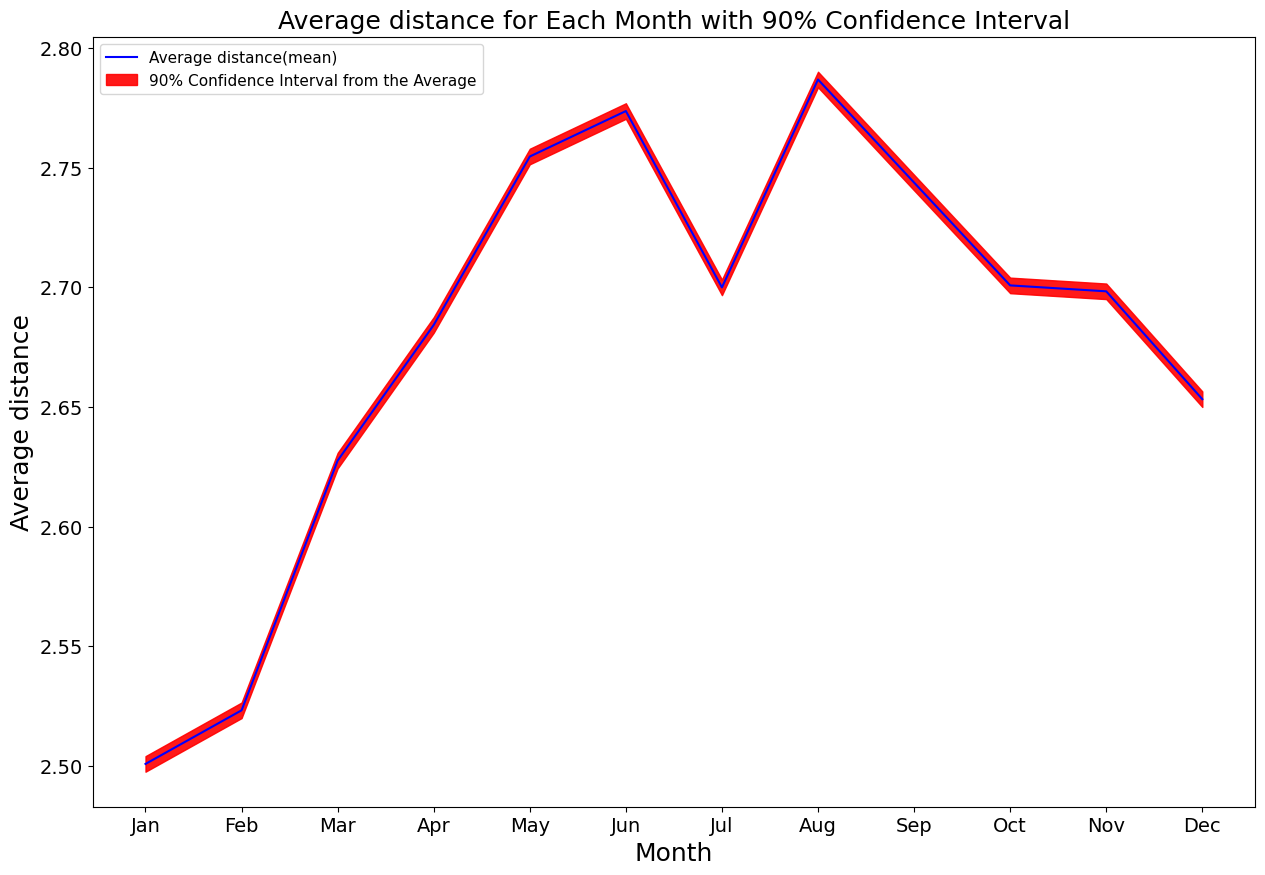

In [48]:
plot_visual_2(df_combined)

### Visualization 3
Here we define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR. We create a set of bar charts that compare what day of the week was most popular for drop offs at each airport.

In [49]:
def inside_airport(dataframe,airport_box):
    """Filters data to dropoff locations inside a designated coordinate range."""
    dataframe = dataframe[ (dataframe['dropoff_latitude'] >= airport_box[1]) & (dataframe['dropoff_latitude'] <= airport_box[3])]
    dataframe = dataframe[ (dataframe['dropoff_longitude'] >= airport_box[0]) & (dataframe['dropoff_longitude'] <= airport_box[2])]
    return dataframe


In [50]:
def clean_airport_data(df_airport):
    """Fetches the data relevant to comparing ride arrivals for each day of the week."""
    df_airport['pickup_datetime']=df_airport['pickup_datetime'].astype('datetime64')
    df_airport=df_airport.groupby(df_airport.pickup_datetime.dt.dayofweek).count()
    df_airport["Day_Of_Week"]=df_airport.index
    df_airport["Count"]=df_airport["pickup_datetime"]
    df_airport.drop(columns=["pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_longitude"],inplace=True)
    return df_airport  

In [53]:
df_uber=pd.read_sql("Select pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude from uber",con=engine)
df_taxi=pd.read_sql("Select pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude from taxi",con=engine)
df_combined=df_uber.append(df_taxi)


C:\Users\johnf\AppData\Local\Temp\ipykernel_11084\4178258206.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined=df_uber.append(df_taxi)


In [54]:
def plot_visual_3(df_combined):
    """Constructs a bar plot comparing ride dropoffs at each of the NYC airports."""
    
    df_vis3_temp=df_combined
    df_newark=inside_airport(df_vis3_temp,NEWARK_BOX)
    df_laguardia=inside_airport(df_vis3_temp,LAGUARDIA_BOX)
    df_jfk=inside_airport(df_vis3_temp,JFK_BOX)

    df_jfk=clean_airport_data(df_jfk)
    df_newark=clean_airport_data(df_newark)
    df_laguardia=clean_airport_data(df_laguardia)

    tags = ["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]
    df = pd.DataFrame({"Newark": tuple(df_newark["Count"]), "Laguardia": tuple(df_laguardia['Count']), "JFK": tuple(df_jfk['Count'])}, index=tags)
    df.plot.bar(rot=0, figsize=(12, 5),xlabel='Day of Week', ylabel='Number of Rides', title='Daywise Number of Rides ending at each airport')
    plt.tight_layout() 
    plt.show()


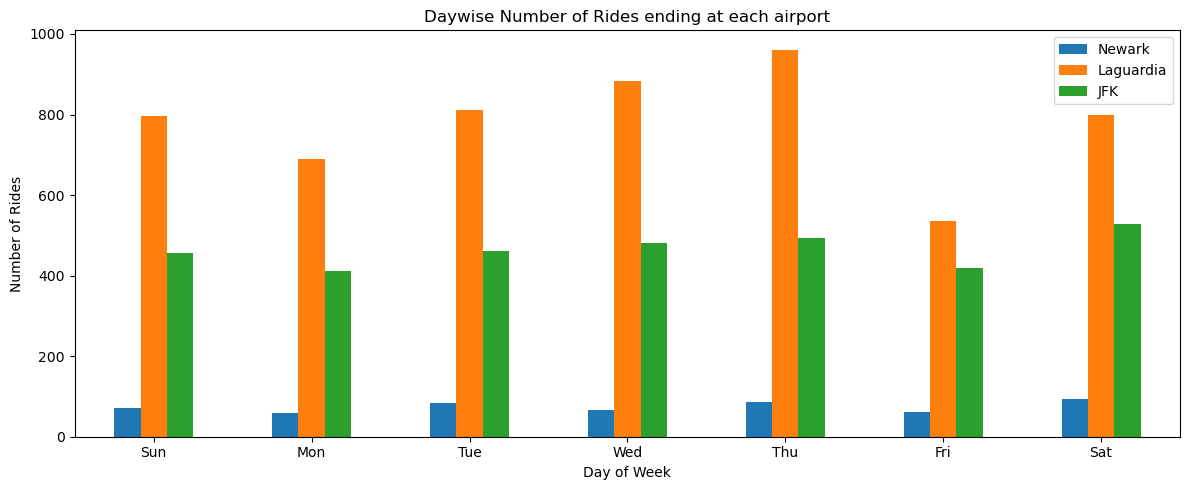

In [55]:
plot_visual_3(df_combined)

### Visualization 4
Here we create a heatmap of all hired trips over a map of the NYC area.

In [56]:
df_uber=pd.read_sql("Select pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude from uber",con=engine)
df_yellow=pd.read_sql("Select pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude from taxi",con=engine)
df_combined=df_uber.append(df_taxi)

C:\Users\johnf\AppData\Local\Temp\ipykernel_11084\2035569777.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined=df_uber.append(df_taxi)


In [57]:
config1={'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '5ubthn',
     'type': 'heatmap',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'start',
      'color': [18, 147, 154],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Start_Lat', 'lng': 'Start_Lon'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'weightField': None, 'weightScale': 'linear'}},
    {'id': '61sipgk',
     'type': 'point',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'end',
      'color': [221, 178, 124],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'End_Lat', 'lng': 'End_Lon', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '1qcteg',
     'type': 'arc',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'start -> end arc',
      'color': [146, 38, 198],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat0': 'Start_Lat',
       'lng0': 'Start_Lon',
       'lat1': 'End_Lat',
       'lng1': 'End_Lon'},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'thickness': 2,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': None},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'e57dwbw',
     'type': 'line',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'start -> end line',
      'color': [136, 87, 44],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat0': 'Start_Lat',
       'lng0': 'Start_Lon',
       'lat1': 'End_Lat',
       'lng1': 'End_Lon',
       'alt0': None,
       'alt1': None},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'thickness': 2,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': None,
       'elevationScale': 1},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'New York City Taxi Trips': [{'name': 'Date',
        'format': None},
       {'name': 'Start_Lon', 'format': None},
       {'name': 'Start_Lat', 'format': None},
       {'name': 'End_Lon', 'format': None},
       {'name': 'End_Lat', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 40.7535153683857,
   'longitude': -73.92178320729087,
   'pitch': 0,
   'zoom': 11.273086327374635,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [58]:
with open("keplertestdata.csv", "w") as my_empty_csv:
    pass

In [59]:
taximap=df_combined[["pickup_longitude","pickup_latitude"]]
taximap.head()

,pickup_longitude,pickup_latitude
0,-73.999817,40.738354
1,-73.994355,40.728225
2,-74.005043,40.740770
3,-73.976124,40.790844
4,-73.925023,40.744085


In [60]:
def plot_visual_4(config1,df_combined):
    """Constructs a heatmap of the rides taken in the NYC area."""
    map_1 = KeplerGl(height=700,config=config1)
    dfkepler=taximap
    df_combined_sub=df_combined.sample(10000)
    map_1.add_data(data=df_combined_sub,name='New York City Taxi Trips')
    return map_1

In [61]:
plot_visual_4(config1,df_combined).save_to_html()


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to keplergl_map.html!


### Visualization 5
Here we create a scatter plot that compares tip amount versus distance for Yellow Taxi rides.

In [62]:
dfvis5=pd.read_sql("Select * from taxi",con=engine)

In [73]:
def plot_visual_5(dfvis5):
    """Constructs a scatter plot comparing tip amount against ride distance."""

    dfvis5=dfvis5[dfvis5["tip_amount"]!=0]
    dfvis5=dfvis5[dfvis5["tip_amount"]<=15]
    dfvis5=dfvis5[dfvis5["distance"]!=0]
    dfvis5=dfvis5[dfvis5["distance"] <= 25]
    dfvis5=dfvis5

    dfvis5sample=dfvis5
    fig, ax = plt.subplots(figsize=(15, 10))
    x = dfvis5sample["distance"]
    y = dfvis5sample["tip_amount"]

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('Distance (in km)',fontsize=18)
    ax.set_ylabel('Tip Amount (in USD)',fontsize=18)
    ax.set_title("Tip Amount v.s. Distance",fontsize=18)


    plt.scatter(x, y)

    plt.show()

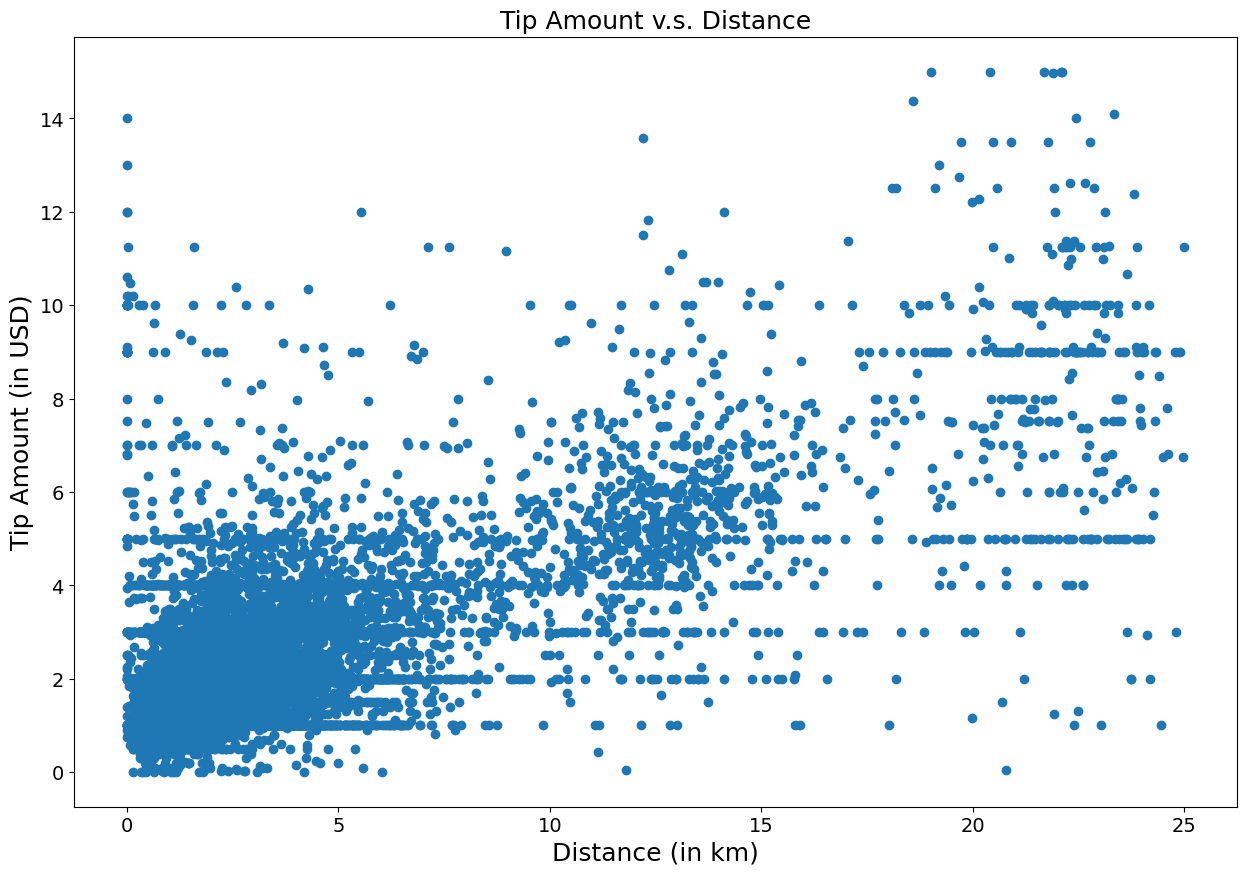

In [74]:
plot_visual_5(dfvis5)

### Visualization 6
Here we create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. 

In [69]:
df_taxi['pickup_datetime'] = pd.to_datetime(df_taxi['pickup_datetime'])
df_taxi['new_date'] = [d.date() for d in df_taxi['pickup_datetime']]
df_taxi['new_time'] = [d.time() for d in df_taxi['pickup_datetime']]

In [70]:
df_hourly.rename(columns = {'id':'DATED'}, inplace = True)
df_hourly['DATED'] = pd.to_datetime(df_hourly['DATED'])
df_hourly['new_dated'] = [d.date() for d in df_hourly['DATED']]
df_hourly['new_timed'] = [d.time() for d in df_hourly['DATED']]
df_hourly['DATED_1'] = df_hourly['DATED_1'].astype(object)
df_hourly['TIMED'] = df_hourly['TIMED'].astype(object)

NameError: name 'df_hourly' is not defined

In [71]:
def plot_visual_6(df_taxi, df_hourly):
    """Contstructs a scatter plot comparing tip amount to hourly precipitation."""
    df_yellow=df_taxi[["pickup_date","tip_amount","distance"]]
    dfvis6 = pd.merge(df_taxi, df_hourly, how='inner', left_on = 'new_date', right_on = 'new_dated')
    dfvis6=dfvis6[dfvis6["tip_amount"]!=0]
    dfvis6=dfvis6[dfvis6["DailyPrecipitation"]!=0]
    dfvis6=dfvis6[dfvis6["DailyPrecipitation"]<=0.5]
    dfvis6=dfvis6[dfvis6["tip_amount"]<=15]
    dfvis6=dfvis6[dfvis6["distance"]!=0]
    dfvis6=dfvis6[dfvis6["distance"] <= 25]


    dfvis6sample=dfvis6
    fig, ax = plt.subplots(figsize=(15, 10))
    x = dfvis6sample["DailyPrecipitation"]
    y = dfvis6sample["tip_amount"]

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('Hourly Precipitation',fontsize=18)
    ax.set_ylabel('Tip Amount',fontsize=18)
    ax.set_title("Tip Amount v.s. Hourly Precipitation",fontsize=18)


    plt.scatter(x, y)

    plt.show()
    dfvis6.head()

In [72]:
plot_visual_6(df_taxi, df_hourly)

NameError: name 'df_hourly' is not defined